In [1]:
import networkx as nx
import scipy.io
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
mat = scipy.io.loadmat('traffic_dataset.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'tra_X_tr', 'tra_X_te', 'tra_Y_tr', 'tra_Y_te', 'tra_adj_mat'])

In [3]:
def sm_to_array(sm):
    return sparse.csr_matrix(sm).toarray()


def convert_to_npm(mat_dict):    
    npm = []

    for i in range(mat_dict.shape[1]):
        sm = mat_dict[:,i][0]
        npm.append(sm_to_array(sm))

    return(np.array(npm))
    

In [4]:
X_train = convert_to_npm(mat['tra_X_tr'])
X_test = convert_to_npm(mat['tra_X_te'])
y_train = mat['tra_Y_tr']
y_test = mat['tra_Y_te']
adj_mat = mat['tra_adj_mat']

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(adj_mat.shape)

(1261, 36, 48)
(840, 36, 48)
(36, 1261)
(36, 840)
(36, 36)


In [6]:
adj_mat

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Next I'll check to see if there are any features that are zeros for all sensors in all the rows

In [7]:
null_count = np.zeros(48)

for time in X_train:
    for f in range(48):
        if sum(X_train[0][:,f]) == 0:
            null_count[f] += 1

In [8]:
null_count

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0., 1261., 1261., 1261., 1261.,    0., 1261., 1261.,
       1261., 1261., 1261., 1261., 1261., 1261., 1261., 1261., 1261.,
       1261., 1261., 1261., 1261., 1261., 1261., 1261., 1261., 1261.,
       1261., 1261., 1261.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.])

In [9]:
null_count = np.zeros(48)

for time in X_test:
    for f in range(48):
        if sum(X_train[0][:,f]) == 0:
            null_count[f] += 1

null_count

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       840., 840., 840., 840.,   0., 840., 840., 840., 840., 840., 840.,
       840., 840., 840., 840., 840., 840., 840., 840., 840., 840., 840.,
       840., 840., 840., 840., 840., 840.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.])

looks like 27 features can be dropped

In [10]:
null_mask = [True if c == 0 else False for c in null_count]

X_train = X_train[:,:,null_mask]
X_test = X_test[:,:,null_mask]

<h3>Graph Structure</h3>

<h4> Nodes </h4>

represents a location with a sensor

Node features:
   Traffic Voume 10  
   week day 7
   hour of day 24
   road direction 4
   Number of lanes
   Name of road
   


<h4> Edges </h4>

represent traffic connectivity between locations/sensors

Since there are no edge features, I'll parametrize the edges between sensors in the model
   
 



In [11]:
adj_mat

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
G = nx.Graph()

G.add_nodes_from(range(36))

for i in range(len(adj_mat)):
    for j in range(i+1,len(adj_mat)):
        if adj_mat[i][j] == 1:
            G.add_edge(i,j)
            G.add_edge(j,i)

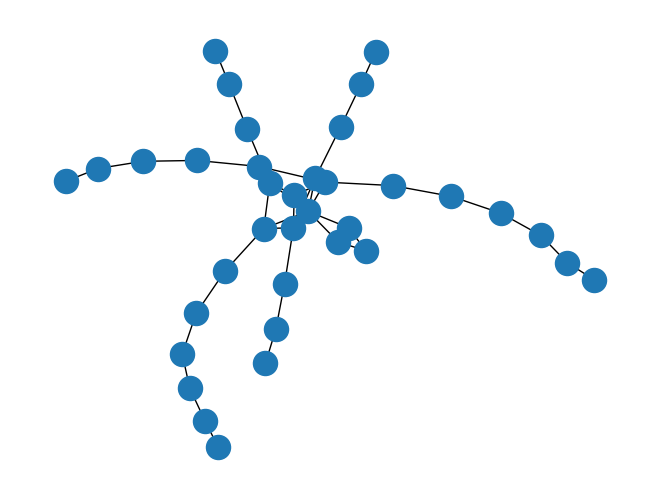

In [13]:
nx.draw(G)

In [14]:
X_train.shape

(1261, 36, 21)

In [15]:
y_train.shape

(36, 1261)

In [16]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

train_iter = StaticGraphTemporalSignal(
    edge_index= np.array(list(G.edges())).transpose(),
    edge_weight=np.ones(len(G.edges)),
    features = X_train,
    targets = y_train.T#[4,:].reshape((1261,1))
)

test_iter = StaticGraphTemporalSignal(
    edge_index= np.array(list(G.edges())).transpose(),
    edge_weight=np.ones(len(G.edges)),
    features = X_test,
    targets = y_test.T#[4,:].reshape((840,1))
)




In [17]:
for time, snapshot in enumerate(train_iter):
    print(snapshot.x.shape)
    print(snapshot.edge_index.shape)
    print(snapshot.edge_attr.shape)
    print(snapshot.num_nodes)
    print(snapshot.num_edge_features)
    print(snapshot.y.shape)
    break

torch.Size([36, 21])
torch.Size([2, 43])
torch.Size([43])
36
1
torch.Size([36])


In [18]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric_temporal.nn.recurrent import GConvLSTM
from torch_geometric.nn.conv import SAGEConv
from torch_geometric.nn.norm import GraphNorm

class GLSTM(torch.nn.Module):
    def __init__(self, node_features, filters,num_edges):
        super(GLSTM, self).__init__()
        self.recurrent = GConvLSTM(node_features, filters, 3)                           
        self.sage = SAGEConv(filters,1,project=True)
        
        self.edge_weights = nn.Parameter(torch.ones(num_edges,dtype=torch.float))
        self.norm = GraphNorm(filters)
        
    def forward(self, x, edge_index, hidden_state, cell_state):
        
        h,c = self.recurrent(x, edge_index, self.edge_weights,H=hidden_state,C=cell_state)
        y = self.norm(h)
        y = F.relu(y)
        y = F.dropout(y)
        y = self.sage(y,edge_index)
        
        
        return y,h,c

In [19]:
from tqdm import tqdm
           

batch_size = 5
model = GLSTM(node_features=21,filters=64,num_edges=43)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

tr_preds = []
tr_y = []

train_loss = []
test_loss = []

In [25]:
t = tqdm(range(400),leave=True)

for epoch in t:
    scale_factor = np.random.choice(np.arange(0.8,1.25,0.05))
    model.train()
    
    H = None
    C = None
    
    
    cost = torch.zeros(1)
    for time, snapshot in enumerate(train_iter):
        augment_y = scale_factor * snapshot.y
        augmented_xf = snapshot.x[:,:10] * scale_factor
        augmented_x = snapshot.x
        augmented_x[:,:10] = augmented_xf
        y_hat,H,C = model(augmented_x, snapshot.edge_index, H, C)
        
        cost = cost + loss(y_hat,augment_y)#torch.mean((y_hat-snapshot.y)**2)
        if time == 1000:
            train_loss.append(cost.detach()/batch_size)
        if time%batch_size == 0 or time == 1260:
            cost.backward()
            optimizer.step()
            
            optimizer.zero_grad()
            cost = 0
            H = H.detach()
            C = C.detach()
        
    with torch.no_grad():
        H_t = None
        C_t = None
        model.eval()
        test_cost = 0
        for ttime, tsnapshot in enumerate(test_iter):
            pred,H_t,C_t = model(tsnapshot.x, tsnapshot.edge_index, H_t,C_t)
            test_cost = test_cost + loss(pred,tsnapshot.y)
            previous = tsnapshot.y
            
        test_cost = test_cost / (ttime+1)
        test_cost = test_cost.item()
        test_loss.append(test_cost)
        
    
    if epoch % 5 == 0:
        torch.save(model.state_dict(),f'models/modelat{len(test_loss)}.pth')
    t.set_description(f'train MSE:{train_loss[-1].item():3f}, test MSE:{test_loss[-1]:3f}')
    

train MSE:0.028464, test MSE:0.025183:  52%|█████▎    | 210/400 [31:26<28:26,  8.98s/it]


KeyboardInterrupt: 

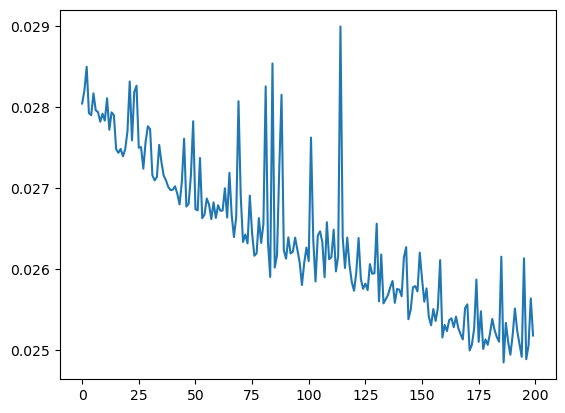

In [27]:
#plt.plot(train_loss[-200:])
plt.plot(test_loss[-200:])


In [ ]:
H_t = None
C_t = None
preds = []
true = []
model.eval()
test_cost = 0
for ttime, tsnapshot in enumerate(test_iter):
    pred,H_t,C_t = model(tsnapshot.x, tsnapshot.edge_index, H_t,C_t)
    test_cost = test_cost + loss(pred,tsnapshot.y)
    preds.append(pred.detach().numpy())
    true.append(tsnapshot.y.detach().numpy())
    # if ttime%batch_size == 0:
    #     H_t = None
    #     C_t = None
test_cost = test_cost / (ttime+1)
test_cost = test_cost.item()
test_loss.append(test_cost)

In [ ]:
test_cost

In [ ]:
preds = np.array(preds).reshape((840,36))
true = np.array(true)

In [ ]:
preds.shape
#true.shape

In [ ]:
for s in range(36):
    plt.plot(true[:,s])
    plt.plot(preds[:,s])
    plt.show()
    

In [ ]:
plt.plot(train_loss[600:])

In [ ]:
test_loss

In [ ]:
for g in optimizer.param_groups:
    g['weight_decay'] == 0

In [23]:
optimizer.param_groups[0]['lr']

0.0001

In [24]:
for g in optimizer.param_groups:
    g['lr'] = 0.00001

In [ ]:
plt.plot(test_loss[50:])

In [ ]:
plt.plot(test_loss[60:])

In [ ]:
c = 0
v = np.min(test_loss)
for i,b in enumerate(test_loss):
    if b == v:
        print(i)

In [ ]:
np.min(test_loss)

In [ ]:
def objective(config):

    class GLSTM(torch.nn.Module):
        def __init__(self, node_features, filters,num_edges):
            super(GLSTM, self).__init__()
            self.recurrentin = GConvLSTM(node_features, filters, config['K'])
            self.recurrent = nn.ModuleList([GConvLSTM(filters, filters, config['K']) for _ in range(config['GNN_cells']-1)])
                                       
            
            self.edge_weight = nn.Parameter(torch.ones(num_edges,dtype=torch.float))
            self.Lw = nn.Parameter(torch.ones((36,filters),dtype=torch.float))
            self.Lb = nn.Parameter(torch.zeros(36,dtype=torch.float))
            
        def forward(self, x, edge_index, hidden_state, cell_state):
            hs = []
            cs = []
            
            h,c = self.recurrentin(x, edge_index, self.edge_weight,H=hidden_state[0],C=cell_state[0])
            hs.append(h)
            cs.append(c)

            for i,cell in enumerate(self.recurrent):
                h_n,c_n = cell(hs[-1], edge_index, self.edge_weight,H=hidden_state[i+1],C=cell_state[i+1])
                hs.append(h_n)
                cs.append(c_n)

            y = F.relu(hs[-1])

            y = torch.tensordot(self.Lw,y,dims=2)
            y = torch.add(y,self.Lb)

            return y,hs,cs
        
    
    model = GLSTM(node_features=48,filters=config['filters'],num_edges=43)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    batch_size = config['batch_size']
    test_loss = []
    

    for epoch in range(200):
        model.train()
        
        H = [None for _ in range(config['GNN_cells'])]
        C = [None for _ in range(config['GNN_cells'])]
        cost = torch.zeros(1)
        for time, snapshot in enumerate(train_iter):
            y_hat,H,C = model(snapshot.x, snapshot.edge_index, H, C)
            cost = cost + torch.mean((y_hat-snapshot.y)**2)
            
            if time%batch_size == 0 or time == 1260:
                cost.backward()
                optimizer.step()
                optimizer.zero_grad()
                cost = 0
                H = [None for _ in range(config['GNN_cells'])]
                C = [None for _ in range(config['GNN_cells'])]
        with torch.no_grad():
            H_t = [None for _ in range(config['GNN_cells'])]
            C_t = [None for _ in range(config['GNN_cells'])]
            model.eval()
            test_cost = 0
            for ttime, tsnapshot in enumerate(test_iter):
                pred,H_t,C_t = model(tsnapshot.x, tsnapshot.edge_index, H_t,C_t)
                test_cost = test_cost + torch.mean((pred-tsnapshot.y)**2)

            test_cost = test_cost / (ttime+1)
            test_cost = test_cost.item()
            test_loss.append(test_cost)
    
    return np.min(test_loss)
    

In [ ]:
from ray import train, tune

search_space = {
    'batch_size':tune.grid_search([3,4,5,6,7]),
    'GNN_cells':tune.grid_search([1,2,3]),
    'K':tune.choice([2,3,4,5]), 
    'filters':tune.choice(range(10,36))
}
tuner = tune.Tuner(objective, param_space=search_space)  # ③

results = tuner.fit()
print(results.get_best_result(metric="score", mode="min").config)

In [ ]:
print(results.get_best_result(metric="_metric", mode="min").config)